# EDA for clustering nodeIDs into Super Categories

These are clusters of nodeIDs which all have similar sales per month trends throughout the year. We believe there will be at least groupings for invariant and seasonal sales. We hope to discover other sales trends from EDA.

We assume the existence of a virtual view created with the following command:

```CREATE VIEW monthly_sales AS
select EXTRACT(MONTH from o.billdate) as mon, p.category as nodeID, sum(o.numunits) as books_sold
from orderlines as o, products as p 
where o.productid = p.productid AND o.totalprice > 0::money
group by p.category, EXTRACT(MONTH from o.billdate)
order by p.category
```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import psycopg2

In [3]:
try:
    conn = psycopg2.connect("dbname='SQLBook' user='postgres' host='localhost' password='postgres1'")
except:
    print ("I am unable to connect to the database")

In [4]:
cur = conn.cursor()

## Get the top 75 nodeIDs
These are the 75 nodeIDs with the most number of books sold.
We'll use this to figure out the "super-categories" and determine how many types of models we need. We assume there will be at least 3 models:
+ invariant = sales in this super-category do not change significantly (remain about almost constant) from month to month
+ seasonally-variant = there 1-3 months where the sales from year to year during these months are consistently high but the other months are invariant sales
+ other = sales that don't fit in the first 2 super-categories. EDA might find further sub-clusters for this based on sentiment analysis or some other variable

In [5]:
cur.execute('SELECT nodeID, sum(books_sold) as total_sold FROM monthly_sales GROUP BY nodeID ORDER BY total_sold DESC LIMIT 75')
dfTotalSoldByNodeID = pd.DataFrame(cur.fetchall(), columns=['nodeID','total_books_sold'], dtype=np.int64)


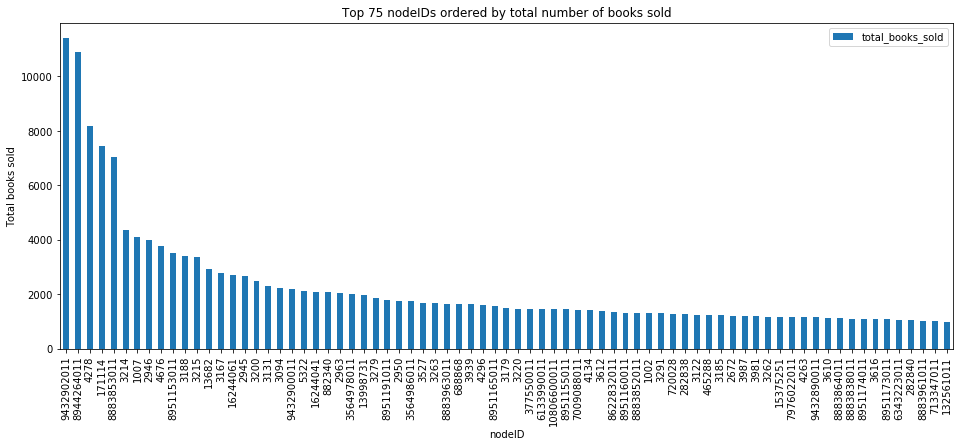

In [6]:
dfTotalSoldByNodeID.plot.bar(x='nodeID', y='total_books_sold', figsize=(16,6), rot=90);

plt.title('Top 75 nodeIDs ordered by total number of books sold');
plt.xlabel('nodeID');
plt.ylabel('Total books sold');

## Let's define a view of these so that it will always be calculated based on the most recent data:

```
CREATE VIEW top75 AS
SELECT nodeID FROM monthly_sales GROUP BY nodeID ORDER BY sum(books_sold) DESC LIMIT 75
```


In [7]:
top75 = cur.execute('SELECT nodeID from top75')
top75 = [int(v[0]) for v in cur.fetchall()] # Return as a list
print('The top 75 categories by total sales are:\n{}'.format(top75))

The top 75 categories by total sales are:
[9432902011, 8944264011, 4278, 171114, 8883853011, 3214, 1007, 2946, 4676, 8951153011, 3188, 3215, 13682, 3167, 16244061, 2945, 3200, 3131, 3094, 9432900011, 5322, 16244041, 882340, 2963, 3564978011, 13998731, 3279, 8951191011, 2950, 3564986011, 3527, 3263, 8883963011, 688868, 3939, 4296, 8951165011, 3179, 3220, 377550011, 6133990011, 10806600011, 8951155011, 7009088011, 4134, 3612, 8622832011, 8951160011, 8883852011, 1002, 3291, 720028, 282838, 3122, 465288, 3185, 2672, 3987, 3981, 3262, 15375251, 7976022011, 4263, 9432890011, 3610, 8883864011, 8883838011, 8951174011, 3616, 8951173011, 6343223011, 282840, 8883961011, 713347011, 132561011]


## Sales trend cross-correlation
Now we define a new view of monthly sales for the top 75 nodeIDs with year added.

```
CREATE VIEW monthly_sales_top75 AS
select EXTRACT(MONTH from o.billdate) as mon, EXTRACT(YEAR from o.billdate) as year, p.category as nodeID, sum(o.numunits) as books_sold
from orderlines as o, products as p, top75 as t
where o.productid = p.productid AND o.totalprice > 0::money AND p.category = t.nodeID
group by p.category, EXTRACT(MONTH from o.billdate), EXTRACT(YEAR from o.billdate)
order by p.category
```

## Get cross product of all top 75 nodeIDs with all 12 months

First get a matrix of all 75 nodeIDs with all 12 months. 
```
CREATE VIEW nodeID_month AS
select cast(m.nodeID AS numeric), g.mon FROM
(select distinct nodeID from monthly_sales_top75) as m 
CROSS JOIN
(select generate_series(1,12) as mon) as g
ORDER by m.nodeID, g.mon
```

Now get the number of books sold per month for these categories/months:

```
CREATE VIEW average_monthly_sales AS
select m.mon as month, m.nodeID, coalesce(t.avg_books_sold, 0) as avg_books_sold
FROM (select mon, nodeID FROM nodeID_month) as m 
LEFT OUTER JOIN (select cast(nodeID as numeric), mon, round(avg(books_sold)) 
AS avg_books_sold FROM monthly_sales_top75 AS t 
GROUP BY nodeID, mon ) AS t 
ON (t.mon = m.mon) AND (t.nodeID = m.nodeID)
ORDER by t.nodeID, m.mon
```

Now the cross-correlation between nodeIDs is done with this:

```
select a.nodeID, b.nodeID, corr(a.avg_books_sold, b.avg_books_sold)
FROM average_monthly_sales as a, average_monthly_sales as b 
where a.nodeID >= b.nodeID and a.month = b.month
GROUP BY a.nodeID, b.nodeID
ORDER BY a.nodeID, b.nodeID
```


In [8]:
cmd = 'select a.nodeID, b.nodeID, corr(a.avg_books_sold, b.avg_books_sold) ' \
'FROM average_monthly_sales as a, average_monthly_sales as b ' \
'where a.nodeID >= b.nodeID and a.month = b.month ' \
'GROUP BY a.nodeID, b.nodeID ' \
'ORDER BY b.nodeID, a.nodeID'

cur.execute(cmd)
corrcf = pd.DataFrame(cur.fetchall(), columns=['nodeID1', 'nodeID2', 'corr_coefficient'])
corrMat = corrcf.pivot('nodeID1', 'nodeID2')

In [9]:
corrMat

corr_coefficient                                          \
nodeID2                 1002      1007      2672      2945      2946   
nodeID1                                                                
1002                1.000000       NaN       NaN       NaN       NaN   
1007                0.733476  1.000000       NaN       NaN       NaN   
2672               -0.197252  0.272713  1.000000       NaN       NaN   
2945               -0.290060 -0.062146  0.762319  1.000000       NaN   
2946               -0.104029  0.225019  0.890264  0.781649  1.000000   
2950               -0.248408 -0.461065 -0.212985 -0.117125 -0.074821   
2963                0.437277 -0.043991 -0.248509 -0.146196 -0.184478   
3094                0.735973  0.457914 -0.127758  0.000930  0.105716   
3122                0.410447  0.696711  0.570728  0.118551  0.652528   
3131                0.293060  0.572865  0.512831  0.027714  0.634738   
3167               -0.082082  0.310172  0.760185  0.283460  0.727728   
3179               -0.013118 -0.084584 -0.214928 -0.191139 -0.331793   
3185                0.348963  0.584133  0.749463  0.448474  0.795990   
3188               -0.288802 -0.517416 -0.429932 -0.263820 -0.297090   
3200                0.025415  0.334306  0.889191  0.808382  0.980366   
3214               -0.172849 -0.428238 -0.325462 -0.135005 -0.228870   
3215                0.085836  0.408864  0.854254  0.565769  0.935026   
3220               -0.525584 -0.318134 -0.153629 -0.122312 -0.179303   
3262                0.052132  0.097015  0.352969  0.152397  0.635800   
3263               -0.482418 -0.240154  0.069860  0.039089  0.045327   
3279               -0.274223  0.095931  0.572440  0.333823  0.666551   
3291                0.750153  0.907691  0.246486  0.028296  0.278468   
3527                0.768733  0.958408  0.244708 -0.083029  0.165135   
3610                0.123838  0.437248  0.827135  0.372495  0.777176   
3612                0.098232  0.385078  0.634230  0.241532  0.787167   
3616               -0.002307  0.378983  0.843796  0.577883  0.861037   
3939                0.108480 -0.228577 -0.143298 -0.076965  0.042602   
3981               -0.044275  0.405407  0.823080  0.309159  0.711356   
3987               -0.146242  0.279405  0.745311  0.310600  0.631334   
4134                0.442937  0.692745  0.602722  0.136392  0.631071   
...                      ...       ...       ...       ...       ...   
16244041            0.224030  0.329439  0.358873  0.103011  0.529872   
16244061            0.282575  0.586920  0.673068  0.209644  0.705529   
132561011          -0.315234 -0.250449 -0.061766 -0.170080 -0.032244   
377550011          -0.039522  0.095903 -0.002147 -0.076458  0.126257   
713347011           0.119431  0.433077  0.629676  0.150126  0.713471   
3564978011          0.126466  0.361746  0.579114  0.280032  0.726527   
3564986011          0.422537  0.446019  0.488940  0.149652  0.550780   
6133990011         -0.074771  0.002223 -0.100578 -0.110206  0.000956   
6343223011         -0.379524 -0.274247 -0.216178 -0.139149 -0.192900   
7009088011          0.468435  0.696360  0.654444  0.333463  0.734567   
7976022011         -0.291303 -0.267304 -0.118162 -0.008183  0.016230   
8622832011         -0.070281 -0.301209 -0.175402  0.025970 -0.023315   
8883838011          0.663111  0.780849 -0.118855 -0.364294 -0.160196   
8883852011          0.028427  0.330481  0.766696  0.372496  0.837008   
8883853011         -0.200193  0.101128  0.878981  0.964402  0.908224   
8883864011         -0.315606 -0.208197  0.020972 -0.109389 -0.132769   
8883961011         -0.119318  0.227543  0.924053  0.889184  0.962270   
8883963011         -0.272931 -0.003958  0.537581  0.711769  0.339984   
8944264011          0.040340  0.242322  0.338392  0.308151  0.296599   
8951153011          0.519590  0.473648  0.268654  0.017660  0.445292   
8951155011          0.139621  0.441415  0.732929  0.394966  0.877901   
8951160011          0.284692  0.420916  0.495253  0.

In [10]:
cMat = corrMat.fillna(0).values
cMat += cMat.T
cMat[cMat == 2] = 1

rows = corrMat.index
columns = rows

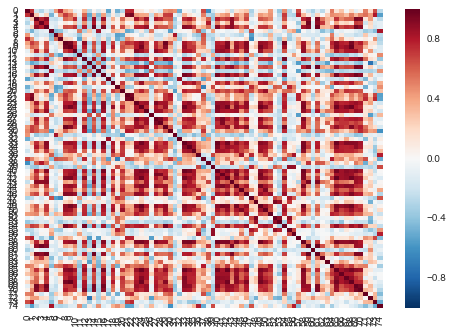

In [11]:
import seaborn as sns

sns.heatmap(cMat);

In [12]:
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import consensus_score

In [62]:
n_clusters = 4
model = SpectralBiclustering(n_clusters=n_clusters, method='log', random_state=816)

In [63]:
model.fit(cMat)

SpectralBiclustering(init='k-means++', method='log', mini_batch=False,
           n_best=3, n_clusters=4, n_components=6, n_init=10, n_jobs=1,
           n_svd_vecs=None, random_state=816, svd_method='randomized')

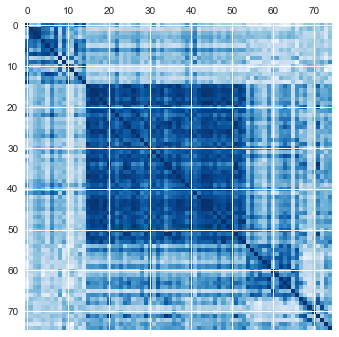

In [64]:
fit_data = cMat[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)

In [65]:
model.get_indices(0)

(array([ 5, 11, 13, 15, 19, 26, 36, 39, 47, 48, 52, 53, 55, 56, 74], dtype=int64),
 array([ 5, 11, 13, 15, 19, 26, 36, 39, 47, 48, 52, 53, 55, 56, 74], dtype=int64))

In [66]:
(r,c) = model.get_indices(3)

In [67]:
columns[c]

Index([2945, 3220, 4296, 282840, 8883864011, 8883963011, 8944264011,
       9432900011],
      dtype='object', name='nodeID1')

## Let's look at sales per month for clustered nodeIDs

Here I'll plot the percentage of books sold over the 12 months. This way we'll match categories by their relative trend over time not by simply the absolute number of books sold.

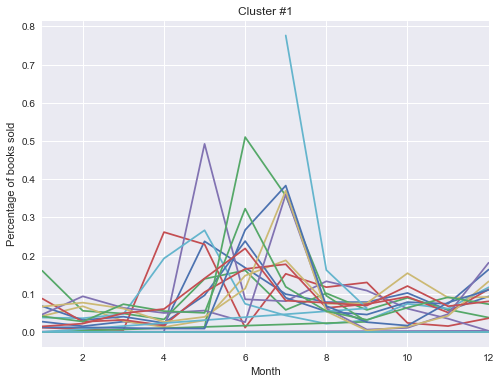

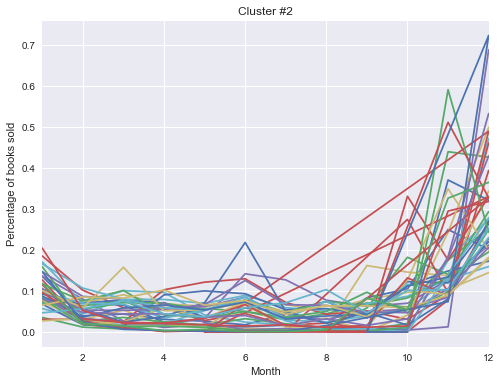

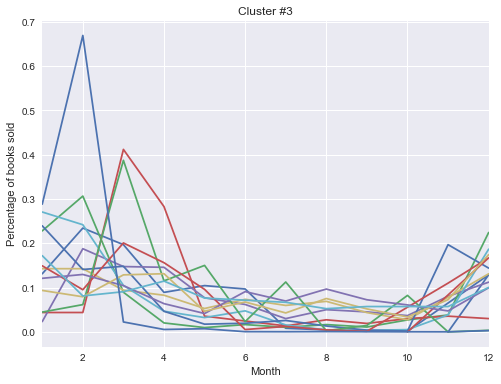

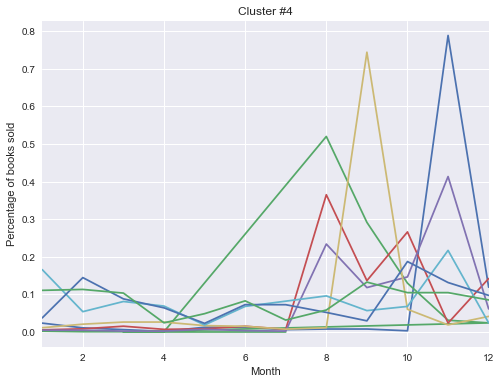

In [84]:
for cluster in range(n_clusters):

    i = 0
    (r,c) = model.get_indices(cluster)
    s = np.zeros((len(c), 12))
    
    cmd = "select month, nodeid, avg_books_sold from average_monthly_sales WHERE nodeid IN {}".format(tuple([int(i) for i in columns[c]]))

    cur.execute(cmd)
    sales1 = pd.DataFrame(cur.fetchall(), columns=['month', 'nodeID', 'avg_books_sold'], dtype=np.int64)
   
    sales1['sum'] = sales1.groupby('nodeID')['avg_books_sold'].transform(sum)
    sales1['percent_sold'] = sales1['avg_books_sold'] / sales1['sum']
    
    fig, ax = plt.subplots(figsize=(8,6))
    sales1.groupby('nodeID').plot(x='month', y='percent_sold', ax=ax, legend=None);
    plt.xlabel('Month')
    plt.ylabel('Percentage of books sold');
    plt.title('Cluster #{}'.format(cluster+1));


In [20]:
#cur.close()  # Close the database connection